In [ ]:
#!pip install datasets

In [ ]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers
import pandas as pd

In [ ]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [ ]:
#from google.colab import drive

#drive.mount('/content/gdrive', force_remount=True)

In [ ]:
from datasets import Dataset

df = pd.read_csv('./WELFake_Dataset.csv', quoting=1, keep_default_na=False)
print(df.info())

dataset = Dataset.from_pandas(df)
split_dataset = dataset.train_test_split(test_size=0.3)
train_data = split_dataset['train']
test_data = split_dataset['test']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       72134 non-null  object
 2   text        72134 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB
None


In [ ]:
transformer_name = "bert-base-uncased"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

/home/sitzmaa/LM/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
tokenizer.tokenize("hello world!")

['hello', 'world', '!']

In [ ]:
tokenizer.encode("hello world!")

[101, 7592, 2088, 999, 102]

In [ ]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

['[CLS]', 'hello', 'world', '[SEP]']

In [ ]:
tokenizer("hello world!")

{'input_ids': [101, 7592, 2088, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

In [ ]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map: 100%|██████████| 21641/21641 [00:19<00:00, 1102.47 examples/s]


In [ ]:
train_data[0]

{'Unnamed: 0': 24190,
 'title': ' GOP Congressman Secretly Scrubbed This Embarrassing Info From His Wikipedia Page (IMAGE)',
 'text': 'A Republican member of Congress was caught scrubbing his Wikipedia page of potentially embarrassing information, including his affiliation with a cult. Rep. David Jolly s (FL) congressional campaign was caught in the act. Jolly is running to replace Senator Marco Rubio after his failed presidential campaign.A spokesman for Rep. David Jolly (R-FL) told BuzzFeed News on Tuesday that the campaign removed certain information, including references to the Church of Scientology, that once appeared on Jolly s Wikipedia page.Spokeswoman Sarah Bascom confirmed to BuzzFeed that the campaign took off parts of the Wikipedia entry that told of Jolly s ties to Scientology. The campaign also removed references to Jolly s past career as a lobbyist and his past positions on gay marriage, according to the report.Jolly told a local newspaper the attempt to hide the informa

In [ ]:
tokenizer.vocab["!"]

999

In [ ]:
tokenizer.pad_token

'[PAD]'

In [ ]:
tokenizer.pad_token_id

0

In [ ]:
tokenizer.vocab[tokenizer.pad_token]

0

In [ ]:
pad_index = tokenizer.pad_token_id

In [ ]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [ ]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [ ]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [ ]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

In [ ]:
transformer.config.hidden_size

768

In [ ]:
output_dim = len(train_data["label"].unique())
freeze = False

model = Transformer(transformer, output_dim, freeze)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 109,483,778 trainable parameters


In [ ]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [ ]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [ ]:
n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

training...:   0%|          | 0/4734 [00:00<?, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
evaluating...: 100%|██████████| 1578/1578 [04:14<00:00,  6.20it/s]


epoch: 0
train_loss: 0.051, train_acc: 0.981
valid_loss: 0.029, valid_acc: 0.991


evaluating...: 100%|██████████| 1578/1578 [04:14<00:00,  6.19it/s]


epoch: 1
train_loss: 0.016, train_acc: 0.994
valid_loss: 0.024, valid_acc: 0.992


evaluating...: 100%|██████████| 1578/1578 [04:15<00:00,  6.18it/s]

epoch: 2
train_loss: 0.008, train_acc: 0.997
valid_loss: 0.025, valid_acc: 0.994


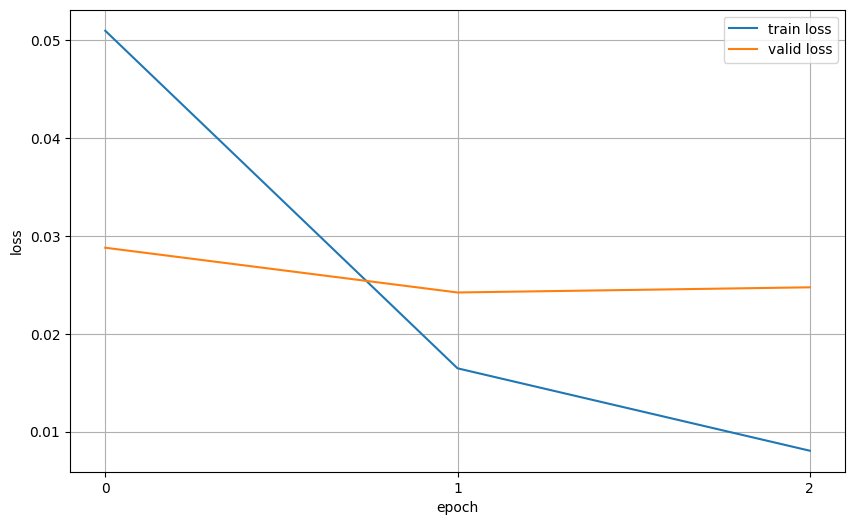

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

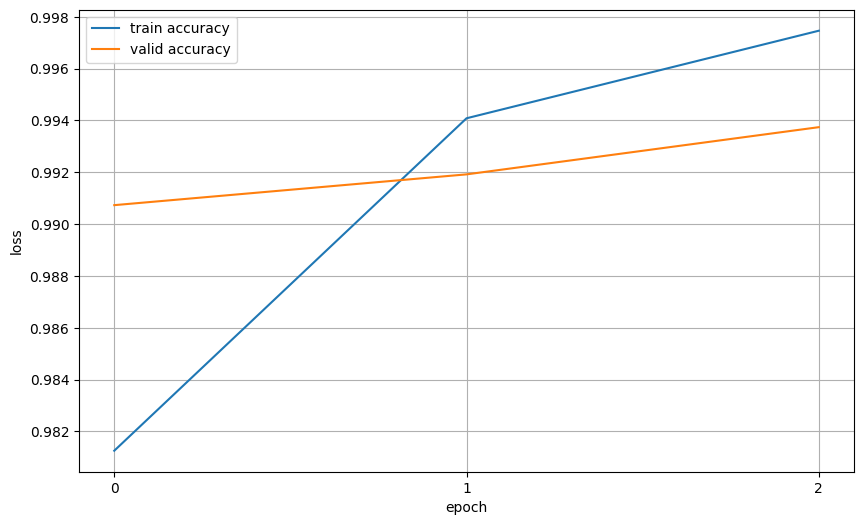

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [ ]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 2706/2706 [07:18<00:00,  6.18it/s]


In [ ]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.024, test_acc: 0.992


In [ ]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [ ]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9843763113021851)

In [ ]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.967552661895752)

In [ ]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.988355278968811)

In [ ]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9893524050712585)

In [ ]:
text = """Japan's transport ministry raided the headquarters of motor giant Toyota on Tuesday, as a scandal over faulty safety data escalated.

The world's largest carmaker has apologised for providing incorrect or manipulated data for safety certification tests.

The scandal has shaken the Japanese car industry, with rivals Honda, Mazda and Suzuki also admitting to submitting faulty data.

Toyota sold more than 11 million passenger vehicles in 2023.

It has said the findings do not affect the safety of vehicles already on the road.

The company has suspended the production of three car models - the Corolla Fielder, Corolla Axio and Yaris Cross.

It has also been accused of using modified vehicles during safety collision tests, for vehicles that are no longer in production.

The raids come a day after Toyota chairman Akio Toyoda apologised to customers and car enthusiasts.

He bowed deeply and held the position for a few seconds, which is customary in Japan when companies apologise for wrongdoing.

"We neglected the certification process and mass produced our cars without first taking the proper precautionary steps,” Mr Toyoda said.
EPA-EFE/REX/Shutterstock Toyota chairman Akio Toyoda bows at the start of a press conference in Tokyo, Japan on 3 June.EPA-EFE/REX/Shutterstock
Toyota chairman Akio Toyoda has apologised for the faulty data

Japanese carmakers Honda, Mazda and Suzuki are also due to be inspected by the authorities over the same issue.

Honda said it found wrongdoing on tests related to noise and engine power, but it has stressed that its vehicles are safe to drive.

Mazda has halted the shipments of some cars and said it will bear the cost to its suppliers.

However, the company added that it is not planning on issuing recalls.

The findings also apply to one Suzuki car model that is no longer being produced.

Last December, Toyota-owned carmaker Daihatsu closed all of its factories for more than a month, after admitting that it had falsified safety tests.

Some of the cars were sold with Toyota branding.

Daihatsu compensated more than 400 domestic suppliers during the period where its plants were idle."""

predict_sentiment(text, model, tokenizer, device)

(0, 0.9994146823883057)

In [ ]:
text = """Jimmy Carter Becomes Second President Convicted Of Felony For Sticking Up Waffle House
PublishedFriday 2:00PM
Image for article titled Jimmy Carter Becomes Second President Convicted Of Felony For Sticking Up Waffle House

PLAINS, GA—On the heels of Donald Trump receiving guilty verdicts on 34 felony counts in New York, Jimmy Carter became the second president ever convicted of a crime Friday after a jury found he broke numerous laws while sticking up a Waffle House near his home in Georgia. “Today’s verdict shows that the rule of law applies to everyone, even a former president of the United States who bursts into a diner, waves around a Glock, and demands all the money in the register plus an All-Star Special with a side of biscuits,” said Sumter Country district attorney Lewis R. Lamb, who spoke on the courthouse steps after securing guilty verdicts on over a dozen counts of armed robbery, aggravated assault, vandalism, and theft. “No one, not even a Nobel Peace Prize laureate, can—for no apparent reason—pistol-whip a patron sitting at a restaurant’s counter and then pour a carafe of piping hot coffee onto his face. Not without facing consequences. Today’s verdict shows that Mr. Carter was not above the law when the police tracked him down in a roadside motel surrounded by empty bottles of Jim Beam and a thousand dollars’ worth of meth and he looked up at his arresting officer and said, ‘The fuck took you so long?’” At press time, Carter’s attorneys had appealed the verdict, saying that his status as a former president gave him complete immunity to do donuts in a Waffle House parking lot while kissing his 17-year-old girlfriend, firing a gun into the air, and shouting, “Wooooooooo! Fuck yeah!”"""
predict_sentiment(text, model, tokenizer, device)

(1, 0.9997653365135193)